# Chuẩn bị dữ liệu

In [1]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score, precision_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

# Load data

In [2]:
from joblib import load
X_test = load('./data/X_test.pkl')
y_test = load('./data/y_test.pkl')
X_train_smote_enn = load('./data/X_train_smote_enn.pkl')
y_train_smote_enn = load('./data/y_train_smote_enn.pkl')

# Hàm đánh giá mô hình

In [3]:
# Hàm đánh giá mô hình
def evaluate_model(model_name, y_test, y_pred, y_pred_proba):
    print(f"\nModel: {model_name}")
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

    metric = {
        "confusion_matrix": cm.tolist(),
        "recall": recall_score(y_test, y_pred, average="binary"),
        "precision": precision_score(y_test, y_pred, average="binary"),
        "f1_score": f1_score(y_test, y_pred, average="binary"),
        "roc_auc": roc_auc_score(y_test, y_pred_proba)
    }
    return metric

In [4]:
metrics = {}

# Random forest

In [5]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote_enn, y_train_smote_enn)
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

In [6]:
metrics['RF'] = evaluate_model("RF", y_test, y_pred_rf, y_pred_proba_rf)


Model: RF
Confusion Matrix:
[[85263    32]
 [   32   116]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.78      0.78      0.78       148

    accuracy                           1.00     85443
   macro avg       0.89      0.89      0.89     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.9716


# ANN

In [8]:
ann = Sequential()
ann.add(Dense(256, activation='relu', input_shape=(X_train_smote_enn.shape[1],)))
ann.add(Dropout(0.3))  # Dropout for regularization
ann.add(Dense(128, activation='relu'))
ann.add(Dropout(0.3))
ann.add(Dense(64, activation='relu'))
ann.add(Dense(1, activation='sigmoid'))

C:\Users\DanHuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = ann.fit(X_train_smote_enn, y_train_smote_enn, epochs=20, batch_size=128)

Epoch 1/20
3108/3108 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9818 - loss: 0.0465
Epoch 2/20
3108/3108 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9985 - loss: 0.0057
Epoch 3/20
3108/3108 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9993 - loss: 0.0034
Epoch 4/20
3108/3108 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9993 - loss: 0.0027
Epoch 5/20
3108/3108 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9995 - loss: 0.0025
Epoch 6/20
3108/3108 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9995 - loss: 0.0024
Epoch 7/20
3108/3108 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9996 - loss: 0.0018
Epoch 8/20
3108/3108 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9996 - loss: 0.0017
Epoch 9/20
3108/3108 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9997 - loss: 0.0018
Epoch 10/20
3108/3108 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9997 - loss: 0.0020
Epoch 11/20
3108/3108 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9997 - loss: 0.0017
Epoch 12/20
3108/3108 ━━━━━━━━

In [10]:
y_pred_proba_ann = ann.predict(X_test)
y_pred_ann = (y_pred_proba_ann > 0.5).astype(int)

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step


In [11]:
metrics['ANN'] = evaluate_model("ANN", y_test, y_pred_ann, y_pred_proba_ann)


Model: ANN
Confusion Matrix:
[[85226    69]
 [   28   120]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.63      0.81      0.71       148

    accuracy                           1.00     85443
   macro avg       0.82      0.91      0.86     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.9576


# LSTM

In [12]:
X_lstm = X_train_smote_enn.values.reshape((X_train_smote_enn.shape[0], 1, X_train_smote_enn.shape[1]))
X_lstm.shape

(397709, 1, 30)

In [13]:
lstm = Sequential()
lstm.add(LSTM(256, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2]), return_sequences=True))
lstm.add(Dropout(0.3))
lstm.add(LSTM(128, activation='relu'))
lstm.add(Dropout(0.3))
lstm.add(Dense(64, activation='relu'))
lstm.add(Dense(1, activation='sigmoid'))

C:\Users\DanHuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = lstm.fit(X_lstm, y_train_smote_enn, epochs=15, batch_size=256)

Epoch 1/15
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9705 - loss: 0.0884
Epoch 2/15
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9990 - loss: 0.0040
Epoch 3/15
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9993 - loss: 0.0026
Epoch 4/15
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9995 - loss: 0.0022
Epoch 5/15
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9996 - loss: 0.0019
Epoch 6/15
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9996 - loss: 0.0023
Epoch 7/15
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9997 - loss: 0.0013
Epoch 8/15
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9997 - loss: 0.0015
Epoch 9/15
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9998 - loss: 0.0014
Epoch 10/15
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9997 - loss: 0.0014
Epoch 11/15
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9998 - loss: 0.0015
Epoch 12/15
1554/1554 ━━━━━━

In [15]:
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_pred_proba_lstm = lstm.predict(X_test_lstm)
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype(int)

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [16]:
metrics['LSTM'] = evaluate_model("LSTM", y_test, y_pred_lstm, y_pred_proba_lstm)


Model: LSTM
Confusion Matrix:
[[85233    62]
 [   27   121]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.66      0.82      0.73       148

    accuracy                           1.00     85443
   macro avg       0.83      0.91      0.87     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.9663


# Lưu kết quả đánh giá vào file JSON

In [17]:
# lưu metrics vào file json
import json

with open('metrics.json', 'w') as f:
    json.dump(metrics, f)
    print("Metrics saved to metrics.json")

Metrics saved to metrics.json


# So sánh ROC-AUC Score

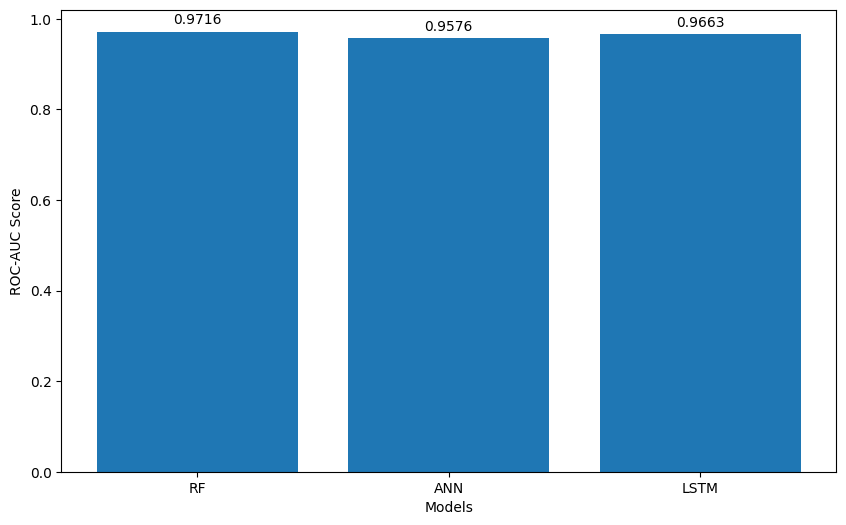

In [18]:


with open('metrics.json', 'r') as f:
    metrics = json.load(f)

models = list(metrics.keys())
roc_auc_scores = [metrics[model]['roc_auc'] for model in models]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, roc_auc_scores)
plt.xlabel('Models')
plt.ylabel('ROC-AUC Score')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')

plt.show()